In [168]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/Users/cmodi/miniconda3/envs/defpyn/lib/python3.8/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['norm', 'test', 'ndim', 'axis', 'normal']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [169]:
import tensorflow as tf
import tensorflow_probability as tfp

# tf.enable_eager_execution()


In [170]:
import pystan

In [171]:
# Target distribution is proportional to: `exp(-x (1 + x))`.
normal = tfp.distributions.Normal

# def unnormalized_log_prob(x):
#   return -x - x**2.
def log_prob(x):
    if len(x.shape) > 1:
        yp = normal(0, 3).log_prob(x[:, 0])
        xp = tf.reduce_sum(tf.stack([normal(0, tf.exp(x[:, 0]/2.)).log_prob(x[:, i]) for i in range(1, x.shape[1])], 1), 1)
    else:
        yp = normal(0, 3).log_prob(x[0])
#         xp = sum([normal(0, tf.exp(x[0]/2.)).log_prob(x[i]) for i in range(1, x.shape[0])])
        xp = tf.reduce_sum([normal(0, tf.exp(x[0]/2.)).log_prob(x[i]) for i in range(1, x.shape[0])])
    return yp + xp
#     return  -y**2 / 9. -x**2/tf.exp(y)



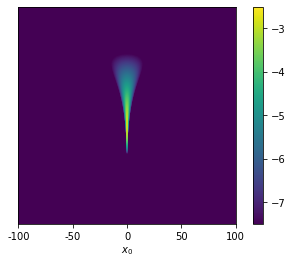

In [172]:
from scipy.stats import norm
fig, ax = plt.subplots()
r = 2000
x, v = np.meshgrid(np.linspace(-20, 20, r).astype(float32), np.linspace(-9, 9, r).astype(float32))
x, v = np.meshgrid(np.linspace(-100, 100, r).astype(float32), np.linspace(-10, 10, r).astype(float32))
xx = np.stack([v.flatten(), x.flatten()]).T
logp2 = log_prob(xx).numpy()
im = ax.imshow(logp2.reshape(r, r), vmin=-7.5, vmax=-2.5, cmap="viridis", origin="lower")
plt.colorbar(im)
ax.set_yticks([])
ax.set_yticklabels([])
ax.set_xticks(np.linspace(0, r-1, 5))
ax.set_xticklabels(np.linspace(x.min(), x.max(), 5).astype(int))
ax.set_xlabel("$x_0$")

xtrue, ytrue, ptrue = v, x, logp2.reshape(r, r)

In [173]:
nchains = 10
ndim = 2
# initstate = tf.reshape(tf.ones(2*ii), (ii,-1)) #[1., 1., 1., 1.],
# initstate = [tf.random.uniform([nchains], -1., 1. ), tf.random.uniform([nchains], -1., 1. )] #[1., 1., 1., 1.],
# initstate = tf.random.uniform([nchains, ndim+1], -3., 3. )
initstate = tf.random.uniform([nchains, ndim+1], -1., 1. )
initstate;

In [174]:
# Initialize the HMC transition kernel.
num_results = int(10e3)
num_burnin_steps = int(1e3)
hmc = tfp.mcmc.HamiltonianMonteCarlo(
        target_log_prob_fn=log_prob,
        num_leapfrog_steps=30,
        step_size=0.1)

# Run the chain (with burn-in).
@tf.function
def run_chain():
    # Run the chain (with burn-in).
    samples, is_accepted = tfp.mcmc.sample_chain(
      num_results=num_results,
      num_burnin_steps=num_burnin_steps,
      current_state= initstate,
      kernel=hmc,
#         trace_fn=lambda _, pkr: pkr.inner_results.is_accepted, 
        trace_fn=lambda _, pkr: [pkr.is_accepted,
                                 pkr.accepted_results.step_size,
                             pkr.log_accept_ratio],
        parallel_iterations=20)

    return samples, is_accepted


In [175]:
start = time.time()
samples, is_accepted = run_chain()
print(time.time()-start)

tfsamples = samples.numpy()

22.376367807388306


In [176]:
print(np.sum(is_accepted[0])/is_accepted[0].numpy().size)
print('step size : ', np.unique(is_accepted[1]))


0.96031
step size :  []


<ipython-input-177-594443c7e57a>:5: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax[2].pcolormesh(xtrue, ytrue, (ptrue), cmap="viridis", vmin=-7, vmax=-2)


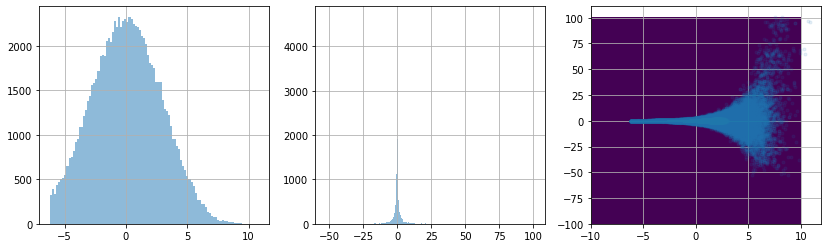

In [177]:
fig, ax = plt.subplots(1, 3, figsize=(14, 4))
ax[0].hist(tfsamples[...,0].flatten(), bins='auto', alpha=0.5)
ax[1].hist(tfsamples[...,1].flatten(), bins='auto', alpha=0.5)
# ax[2].pcolormesh(xtrue, ytrue, np.exp(ptrue) , vmin=0, vmax=0.1, cmap="viridis")
ax[2].pcolormesh(xtrue, ytrue, (ptrue), cmap="viridis", vmin=-7, vmax=-2)
ax[2].plot(tfsamples[...,0].flatten(), tfsamples[...,1].flatten(),'.', alpha=0.1)
for axis in ax: axis.grid(which='both')

<ipython-input-178-2076f4e765d8>:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xtrue, ytrue, (ptrue), cmap="viridis", vmin=-7, vmax=-2)


(-20.0, 20.0)

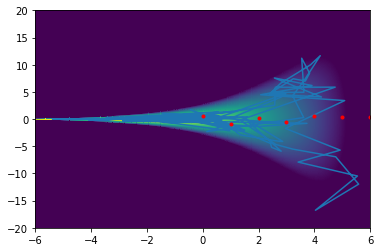

In [178]:
plt.plot(*tfsamples[:100, 0].T, 'r.')
# plt.pcolormesh(xtrue, ytrue, np.exp(ptrue), cmap="hot", vmin=0, vmax=0.01)
plt.pcolormesh(xtrue, ytrue, (ptrue), cmap="viridis", vmin=-7, vmax=-2)
plt.xlim(-6, 6)
plt.ylim(-20, 20)

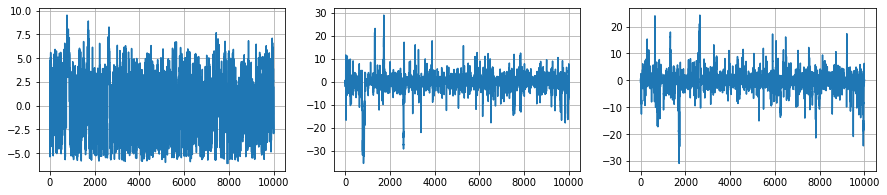

In [179]:
fig, ax = plt.subplots(1, ndim+1, figsize=(15, 3))
for i in range(len(ax)):
    ax[i].plot(tfsamples[:, 0, i])
    ax[i].grid()

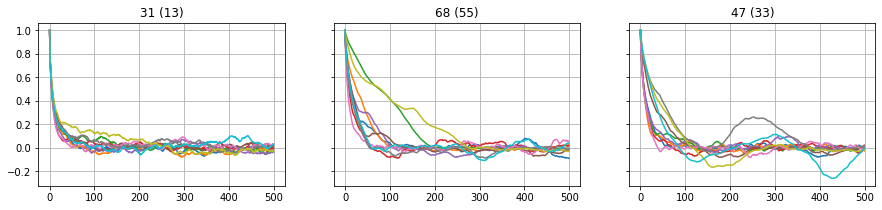

In [180]:
fig, ax = plt.subplots(1, ndim+1, figsize=(15, 3), sharex=True, sharey=True)
for i in range(len(ax)):
    x = tfsamples[...,i]
    xp = (x - x.mean(axis=0))/x.std(axis=0)
    rcc = np.array([np.correlate(xp[:, i], xp[:, i], mode='full') for i in range(xp.shape[1])])
    rcc = rcc[:, rcc.shape[1]//2:].T
    rcc /= rcc[0]
    ax[i].plot(rcc[:500])
    ax[i].grid()
    #
    tcc = []
    for j in range(x.shape[1]):
        for m in range(500):
            if m > 5*(1 + 2*rcc[:m, j].sum()): break
        tcc.append((1 + 2*rcc[:m, j].sum()))
    tcc = np.array(tcc)
    ax[i].set_title('%d (%d)'%(tcc.mean(), tcc.std()))

# MY HMC

In [181]:
V = lambda x: -1* log_prob(x)

@tf.function
def KE(p):
    print(p.shape)
    return 0.5 * tf.reduce_sum(p**2)


@tf.function
def H(q,p):
    return V(q) + KE(p)

@tf.function
def get_grads(f, x):
    with tf.GradientTape() as tape:
        tape.watch(x)
        fv = f(x)
    grad = tape.gradient(fv, x)
    return fv, grad
    

@tf.function
def leapfrog(N, q, p, step_size, V, K):
    p = p - 0.5*step_size * get_grads(V, q)[1]
    for i in range(N-1):
        q = q + step_size * get_grads(K, p)[1]
        p = p - step_size * get_grads(V, q)[1]
    q = q + step_size * get_grads(K, p)[1]
    p = p - 0.5*step_size * get_grads(V, q)[1]
    return q, p

@tf.function
def leapfrog_steps(N, q, p, step_size, V, K):
    toret = []
    for i in range(N):
        g0 = get_grads(V, q)
        phalf = p - 0.5*step_size * g0[1]
        q1 = q + step_size * get_grads(K, phalf)[1]
        g1 = get_grads(V, q1)
        p1 = phalf - 0.5*step_size * g1[1]
        toret.append([[q, q1], [p, phalf,p1], [g0, g1]])
        p = p1
        q = q1
    return q, p, toret


@tf.function
def metropolis(qp0, qp1, H):
    q0, p0 = qp0
    q1, p1 = qp1
    H0 = H(q0, p0)
    H1 = H(q1, p1)
    prob = tf.minimum(1., tf.exp(H0 - H1))
    if tf.math.is_nan(prob): 
        return q0, p0, 2.
    if tf.random.uniform([1], maxval=1.) > prob:
        return q0, p0, 0.
    else: return q1, p1, 1.
        
    


In [182]:
step_size = 0.1
Nleapfrog = 10 
nsamples, burnin = 1000, 1000
mysamples = []
myis_accepted = []
q = tf.constant([1., 1.])
# q = tf.constant([1.])
p = tf.random.normal(shape=q.shape)
V(q), KE(p), H(q, p);
nparallel = 10
nchains = 20



(2,)
(2,)


In [ ]:
samples = tf.TensorArray(dtype=tf.float32, size=nsamples)
i = tf.constant(0)


# @tf.function
# def step(q):
#     q = tf.map_fn(hmc_step, q, parallel_iterations=nparallel)
#     return q

@tf.function
def hmc_step(q, step_size=step_size):
    p = tf.random.normal(shape=q.shape)
    q1, p1 = leapfrog(Nleapfrog, q, p, step_size, V, KE)
    q, p, accepted = metropolis([q, p], [q1, p1], H)
    return q


@tf.function
def hmc_step_qp(q, p, Nleapfrog=Nleapfrog, step_size=step_size):
    q1, p1 = leapfrog(Nleapfrog, q, p, step_size, V, KE)
    q, p, accepted = metropolis([q, p], [q1, p1], H)
    return q


def hmc_body(i, q, samples):
    q = tf.map_fn(hmc_step, q, parallel_iterations=nparallel)
    samples = samples.write(i, q)
    return i+1, q, samples

def cond(i, q, samples):
    return tf.less(i, tf.constant(nsamples))

start = time.time()
i, q, mysamples = tf.while_loop(cond, hmc_body, [i, initstate, samples], parallel_iterations=nparallel)
end = time.time()
print(end - start)
mysamples = mysamples.stack().numpy()

In [302]:
@tf.function
def hmc_step_qp(q, p, Nleapfrog=Nleapfrog, step_size=step_size):
    q1, p1 = leapfrog(Nleapfrog, q, p, step_size, V, KE)
    q, p, accepted = metropolis([q, p], [q1, p1], H)
    return q


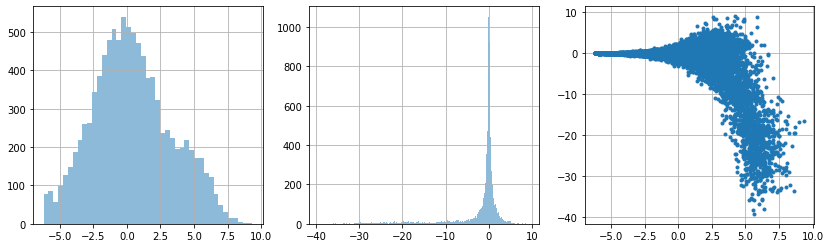

In [184]:
ii = 1
fig, ax = plt.subplots(1, 3, figsize=(14, 4))
ax[0].hist(mysamples[...,0].flatten(), bins='auto', alpha=0.5)
ax[1].hist(mysamples[...,ii].flatten(), bins='auto', alpha=0.5)
ax[2].plot(mysamples[...,0].flatten(), mysamples[...,1].flatten(),'.')
for axis in ax: axis.grid(which='both')

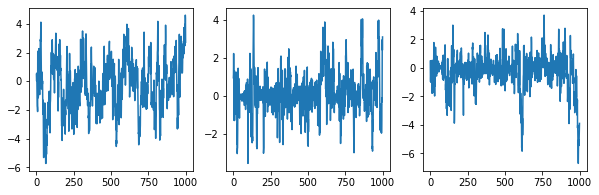

In [185]:
fig, ax = plt.subplots(1, ndim+1, figsize=(3*ndim+4, 3))
for i in range(len(ax)):
    ax[i].plot(mysamples[:, 0, i])


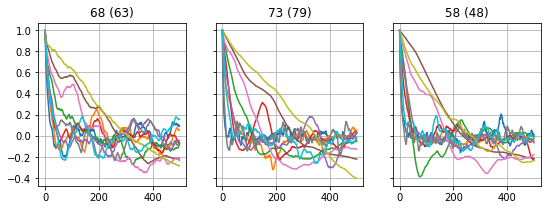

In [186]:
nplot = ndim+1
fig, ax = plt.subplots(1, nplot, figsize=(3*nplot, 3), sharex=True, sharey=True)
for i in range(len(ax)):
    x = mysamples[...,i]
    xp = (x - x.mean(axis=0))/x.std(axis=0)
    rcc = np.array([np.correlate(xp[:, i], xp[:, i], mode='full') for i in range(xp.shape[1])])
    rcc = rcc[:, rcc.shape[1]//2:].T
    rcc /= rcc[0]
    ax[i].plot(rcc[:500])
    ax[i].grid()
    #
    tcc = []
    for j in range(x.shape[1]):
        for m in range(500):
            if m > 5*(1 + 2*rcc[:m, j].sum()): break
        tcc.append((1 + 2*rcc[:m, j].sum()))
    tcc = np.array(tcc)
    ax[i].set_title('%d (%d)'%(tcc.mean(), tcc.std()))

# PyStan

In [187]:
import pystan

In [188]:
model_code_funnel = """
parameters {
  real v; 
  real theta;
}


model {
v ~ normal(0, 3);
theta ~ normal(0, exp(v/2));
}
"""


In [189]:
# sstan =  pystan.stan(model_code=model_code_funnel)
# .build(model_code_funnel)

In [292]:
def save_model(obj, filename):
    """Save compiled models for reuse."""
    import pickle
    with open(filename, 'wb') as f:
        pickle.dump(obj, f, protocol=pickle.HIGHEST_PROTOCOL)

def load_model(filename):
    """Reload compiled models for reuse."""
    import pickle
    return pickle.load(open(filename, 'rb'))


fname = '../scripts/models/funnel_3dim.pkl'
# fname = None #'./scripts/models/funnel_2dim.pkl'

start = time.time()
try:
    sm_funnel = load_model(fname)
    print("Model loaded from %s"%fname, sm_funnel)
except Exception as e:
    print(e)
    sm_funnel = pystan.StanModel(model_code=model_code_funnel)
    save_model(sm_funnel, fname)
    print("model saved in %s"%fname)

print("Time to make model : ", time.time()-start)


Model loaded from ../scripts/models/funnel_3dim.pkl StanModel object 'anon_model_d6c85c98517d309b57378fa151dbb6f1' coded as follows:

parameters {
  real v; 
  vector[2] theta;
}


model {
v ~ normal(0, 3);
theta ~ normal(0, exp(v/2));
}

Time to make model :  0.0034329891204833984


In [351]:
start = time.time()
samples = sm_funnel.sampling(iter=20000, chains=1, algorithm="HMC", seed=100, n_jobs=1, 
                             init=1,  #[{'v':i[0], 'theta':i[1:]} for i in initstate.numpy()[0:1]],
                     control={"stepsize":0.1, 
                                "adapt_t0":False,
                                "adapt_delta":False,
                                "adapt_kappa":False,
                                "metric":"unit_e",
                              "int_time":5
                                })
end = time.time()
print(end - start)

1.1372270584106445


In [294]:
samples.extract()['theta'].shape

(10000, 2)

In [193]:
samples.get_adaptation_info()

['# Adaptation terminated\n# Step size = 0.1\n']

In [194]:
samples.grad_log_prob([1., 1., 1.])

array([-0.74323167, -0.36787944, -0.36787944])

In [195]:
ss = samples.extract()
ss['v']
# ss = np.array([ss[i] for i in ss.keys()])

array([-5.76813153, -2.15689289, -0.85503996, ..., -4.91810436,
       -5.18154299,  3.36322913])

In [196]:
np.hstack([ss['v'].reshape(-1, 1), ss['theta']])

array([[-5.76813153, -0.01886318, -0.0874498 ],
       [-2.15689289,  0.26322814, -0.53614786],
       [-0.85503996,  0.17828841, -0.95070119],
       ...,
       [-4.91810436, -0.02127354, -0.09475797],
       [-5.18154299,  0.08039633,  0.00862975],
       [ 3.36322913, -5.58040765,  1.27247794]])

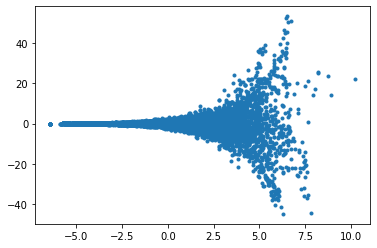

In [197]:
plt.plot(ss['v'], ss['theta'][:, 0], '.')

In [198]:
xx = np.random.uniform(-1, 1, 3).astype(float32)
xx2 = np.random.uniform(-1, 1, 3).astype(float32)

In [199]:
samples.log_prob(xx), samples.log_prob(xx2)

(-0.36989580204386174, -0.6389742621732561)

In [200]:
# log_prob(np.expand_dims(xx[::-1], 0)), log_prob(np.expand_dims(xx2[::-1], 0))
log_prob(np.expand_dims(xx, 0)), log_prob(np.expand_dims(xx2, 0))

(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([-4.2253237], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([-4.494403], dtype=float32)>)

In [201]:
# log_prob(np.expand_dims(xx[::-1], 0))-samples.log_prob(xx), log_prob(np.expand_dims(xx2[::-1], 0))-samples.log_prob(xx2)
log_prob(np.expand_dims(xx, 0))-samples.log_prob(xx), log_prob(np.expand_dims(xx2, 0))-samples.log_prob(xx2)

(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([-3.8554277], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([-3.8554287], dtype=float32)>)

In [202]:
samples.grad_log_prob(xx)

array([-0.3863047 , -1.18922329, -0.23768606])

In [203]:
get_grads(V, xx)[1]

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([0.38630477, 1.1892233 , 0.23768607], dtype=float32)>

# Pystan hmc

In [295]:
pyV = samples.log_prob
pyV_g = samples.grad_log_prob

def pyKE(p):
    return 0.5 * (p**2).sum()

def pyKE_g(p):
    return p

def pyH(q,p):
    return pyV(q) *-1. + pyKE(p)

    

def pyleapfrog(N, q, p, step_size):
    p = p - 0.5*step_size * pyV_g(q) *-1.
    for i in range(N-1):
        q = q + step_size * pyKE_g(p)
        p = p - step_size * pyV_g(q) *-1.
    q = q + step_size * pyKE_g(p)
    p = p - 0.5*step_size * pyV_g(q) *-1.
    return q, p


def pymetropolis(qp0, qp1):
    q0, p0 = qp0
    q1, p1 = qp1
    H0 = pyH(q0, p0)
    H1 = pyH(q1, p1)
    prob = min(1., np.exp(H0 - H1))
    if np.isnan(prob): 
        return q0, p0, 2.
    if np.random.uniform(size=1) > prob:
        return q0, p0, 0.
    else: return q1, p1, 1.
        
    
def pyhmc_step(q, N, step_size):
    p = np.random.normal(size=q.size).reshape(q.shape)
    q1, p1 = pyleapfrog(N, q, p, step_size)
    q, p, accepted = pymetropolis([q, p], [q1, p1])
    return q

def pyhmc_step_qp(q, p, N, step_size):
    q1, p1 = pyleapfrog(N, q, p, step_size)
    q, p, accepted = pymetropolis([q, p], [q1, p1])
    return q



In [296]:
qq = initstate.numpy().astype(float32)
pp = np.random.normal(size=qq.size).reshape(qq.shape).astype(qq.dtype)


In [257]:
print([H(qq[ii], pp[ii]).numpy() for ii in range(10)])
ii = 0 
np.array([pyH(qq[ii], pp[ii]) for ii in range(10)]) -np.array( [H(qq[ii], pp[ii]).numpy() for ii in range(10)])

[6.9682064, 6.4125514, 4.3921385, 6.120425, 5.5915875, 6.039288, 4.470975, 4.5971565, 5.5841327, 4.828857]


array([-3.85542759, -3.85542764, -3.85542808, -3.85542824, -3.85542806,
       -3.85542747, -3.85542813, -3.8554282 , -3.8554281 , -3.85542806])

In [258]:
print(KE(pp).numpy())
ii = 0 
np.array([pyH(qq[ii], pp[ii]) for ii in range(10)]) #- H(qq, pp)

13.2712555


array([3.11277882, 2.55712376, 0.5367104 , 2.26499699, 1.73615948,
       2.18386058, 0.6155468 , 0.74172832, 1.72870458, 0.97342889])

In [259]:
ii = 0
iq, ip = qq[ii], pp[ii]
fq, fp = pyleapfrog(Nleapfrog, iq, ip, step_size)
iq2, ip2 = pyleapfrog(Nleapfrog, fq, -fp, step_size)
fqt, fpt =  leapfrog(Nleapfrog, tf.constant(iq, dtype=tf.float32), tf.constant(ip, dtype=tf.float32), step_size, V, KE)

In [260]:
iq#, ip

array([0.34296894, 0.54831743, 0.16979742], dtype=float32)

In [261]:
fqt.numpy(), fq

(array([0.69894844, 0.15735835, 2.0950806 ], dtype=float32),
 array([0.6989485 , 0.15735835, 2.09508055]))

In [262]:
fpt.numpy(), fp

(array([ 0.15855175, -0.4738779 ,  1.5275955 ], dtype=float32),
 array([ 0.15855172, -0.4738779 ,  1.52759554]))

In [263]:
fqt, fpt =  leapfrog(Nleapfrog, tf.constant(qq, dtype=tf.float32), tf.constant(pp, dtype=tf.float32), step_size, V, KE)
fqp = list(map(lambda x: pyleapfrog(Nleapfrog, x[0], x[1], step_size), zip(qq, pp)))
fp = np.array([i[1] for i in fqp])
fq = np.array([i[0] for i in fqp])


In [264]:
fq/fqt, fp/fpt


(<tf.Tensor: shape=(10, 3), dtype=float32, numpy=
 array([[1.0000001 , 1.        , 1.        ],
        [1.0000001 , 0.9999998 , 1.0000001 ],
        [1.        , 1.0000162 , 0.9999999 ],
        [0.99999994, 1.0000014 , 1.0000005 ],
        [0.99999994, 1.        , 1.        ],
        [0.99999976, 0.9999998 , 1.0000001 ],
        [0.99999994, 1.0000002 , 1.0000001 ],
        [0.99999994, 0.9999999 , 1.0000001 ],
        [1.        , 1.        , 0.9999998 ],
        [0.99999756, 1.        , 0.9999997 ]], dtype=float32)>,
 <tf.Tensor: shape=(10, 3), dtype=float32, numpy=
 array([[0.9999998 , 1.        , 1.        ],
        [1.0000006 , 0.9999999 , 1.0000002 ],
        [0.99999994, 0.99999994, 0.9999999 ],
        [0.9999998 , 0.9999999 , 0.99999994],
        [1.0000001 , 1.        , 1.0000001 ],
        [0.99999994, 1.        , 1.        ],
        [1.        , 1.        , 1.0000001 ],
        [1.0000007 , 0.9999998 , 0.99999994],
        [0.99999994, 1.0000001 , 1.        ],
        

In [265]:
# mysamples = tf.TensorArray(dtype=tf.float32, size=nsamples)
# i = tf.constant(0)

# def hmc_body(i, q, mysamples):
#     q = tf.map_fn(hmc_step, q, parallel_iterations=nparallel)
#     samples = mysamples.write(i, q)
#     return i+1, q, samples

# def cond(i, q, samples):
#     return tf.less(i, tf.constant(nsamples))

# start = time.time()
# i, q, mysamples = tf.while_loop(cond, hmc_body, [i, initstate, samples], parallel_iterations=nparallel)
# end = time.time()
# print(end - start)
# mysamples = mysamples.stack().numpy()

In [266]:
5//step_size

49.0

In [267]:
pysamples = []

start = time.time()
q = iq
nsamples = 10000
for i in range(nsamples):
    q = pyhmc_step(q, int(5//0.1), 0.1)
    pysamples.append(q)
q = np.array(q)
end = time.time()
print(end - start)
pysamples = np.array(pysamples)

3.6933388710021973


In [268]:
pysamples.shape

(10000, 3)

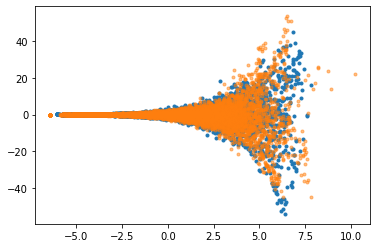

In [275]:
# plt.plot(pysamples[nsamples//2:, 0], pysamples[nsamples//2:, 1], '.')
plt.plot(pysamples[:, 0], pysamples[:, 1], '.')
plt.plot(ss['v'], ss['theta'][:, 0], '.', alpha=0.5)

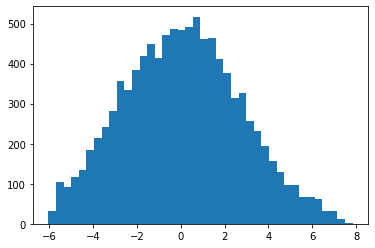

In [270]:
plt.hist(pysamples[:, 0], bins='auto');

In [273]:
i = 0 
metropolis([tf.constant(qq[i], tf.float32), tf.constant(pp[i], tf.float32)],
           [tf.constant(fq[i], tf.float32), tf.constant(fp[i], tf.float32)], H)

(<tf.Tensor: shape=(3,), dtype=float32, numpy=array([0.6989485 , 0.15735835, 2.0950806 ], dtype=float32)>,
 <tf.Tensor: shape=(3,), dtype=float32, numpy=array([ 0.15855172, -0.4738779 ,  1.5275955 ], dtype=float32)>,
 <tf.Tensor: shape=(), dtype=float32, numpy=1.0>)

In [ ]:
fq = np.array(list(map(lambda x: pyhmc_step(x, Nleapfrog, step_size), qq)))

In [406]:
fqt = tf.map_fn(hmc_step, initstate, parallel_iterations=nparallel).numpy()


In [411]:
iq, ip

(array([0.17990184, 0.42478561]), array([-0.86314631, -1.14431367]))

In [242]:
hmc_step(q)

TypeError: in user code:

    <ipython-input-183-5da389b102dd>:13 hmc_step  *
        q1, p1 = leapfrog(Nleapfrog, q, p, step_size, V, KE)
    <ipython-input-181-60bface716f4>:24 leapfrog  *
        p = p - 0.5*step_size * get_grads(V, q)[1]
    <ipython-input-181-60bface716f4>:17 get_grads  *
        fv = f(x)
    <ipython-input-181-60bface716f4>:1 None  *
        lambda x: -1* log_prob(x)
    <ipython-input-171-a52c2c45a651>:11 log_prob  *
        yp = normal(0, 3).log_prob(x[0])
    /Users/cmodi/.local/lib/python3.8/site-packages/tensorflow_probability/python/distributions/distribution.py:1030 log_prob  **
        return self._call_log_prob(value, name, **kwargs)
    /Users/cmodi/.local/lib/python3.8/site-packages/tensorflow_probability/python/distributions/distribution.py:1012 _call_log_prob
        return self._log_prob(value, **kwargs)
    /Users/cmodi/.local/lib/python3.8/site-packages/tensorflow_probability/python/distributions/normal.py:198 _log_prob
        x / scale, self.loc / scale)
    /Users/cmodi/.local/lib/python3.8/site-packages/tensorflow/python/ops/math_ops.py:1180 binary_op_wrapper
        raise e
    /Users/cmodi/.local/lib/python3.8/site-packages/tensorflow/python/ops/math_ops.py:1164 binary_op_wrapper
        return func(x, y, name=name)
    /Users/cmodi/.local/lib/python3.8/site-packages/tensorflow/python/util/dispatch.py:201 wrapper
        return target(*args, **kwargs)
    /Users/cmodi/.local/lib/python3.8/site-packages/tensorflow/python/ops/math_ops.py:1336 truediv
        return _truediv_python3(x, y, name)
    /Users/cmodi/.local/lib/python3.8/site-packages/tensorflow/python/ops/math_ops.py:1266 _truediv_python3
        raise TypeError("x and y must have the same dtype, got %r != %r" %

    TypeError: x and y must have the same dtype, got tf.float64 != tf.float32


In [408]:
# %timeit leapfrog(N, qq, pp, step_size, V, KE)
# %timeit fq, fp = pyleapfrog(N, iq, ip, step_size), iq
# %timeit list(map(lambda x: pyleapfrog(N, x[0], x[1], step_size), zip(qq, pp)))

# pyHMC class

In [274]:
# pyV = samples.log_prob
# pyV_g = samples.grad_log_prob

class PyHMC():
    
    def __init__(self, log_prob, grad_log_prob, KE=None, KE_g=None):

        self.log_prob, self.grad_log_prob = log_prob, grad_log_prob
        self.V = lambda x : self.log_prob(x)*-1.
        self.V_g = lambda x : self.grad_log_prob(x)*-1.
        
        if KE is None or KE_g is None:
            self.KE = self.unit_norm_KE
            self.KE_g = self.unit_norm_KE_g
            
    def unit_norm_KE(self, p):
        return 0.5 * (p**2).sum()

    def unit_norm_KE_g(self, p):
        return p

    def H(self, q,p):
        return self.V(q) + self.KE(p)


    def leapfrog(self, q, p, N, step_size):
        p = p - 0.5*step_size * self.V_g(q) 
        for i in range(N-1):
            q = q + step_size * self.KE_g(p)
            p = p - step_size * self.V_g(q) 
        q = q + step_size * self.KE_g(p)
        p = p - 0.5*step_size * self.V_g(q) 
        return q, p


    def metropolis(self, qp0, qp1):
        q0, p0 = qp0
        q1, p1 = qp1
        H0 = self.H(q0, p0)
        H1 = self.H(q1, p1)
        prob = min(1., np.exp(H0 - H1))
        if np.isnan(prob): 
            return q0, p0, 2.
        if np.random.uniform(size=1) > prob:
            return q0, p0, 0.
        else: return q1, p1, 1.


    def hmc_step(self, q, N, step_size):
        p = np.random.normal(size=q.size).reshape(q.shape)
        q1, p1 = self.leapfrog(q, p, N, step_size)
        q, p, accepted = self.metropolis([q, p], [q1, p1])
        return q, p, accepted



In [505]:
testhmc = PyHMC(samples.log_prob, samples.grad_log_prob)

In [506]:
pysamples = []

start = time.time()
q = iq
nsamples = 10000
for i in range(nsamples):
    q = testhmc.hmc_step(q, int(5//0.1), 0.1)[0]
    pysamples.append(q)
q = np.array(q)
end = time.time()
print(end - start)
pysamples = np.array(pysamples)

3.9935832023620605


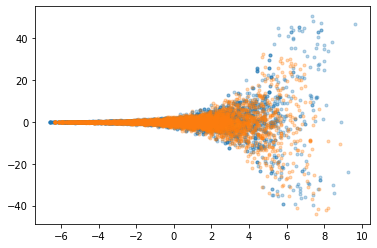

In [507]:
plt.plot(pysamples[nsamples//2:, 0], pysamples[nsamples//2:, 1], '.', alpha=0.3)
plt.plot(ss[0], ss[1], '.', alpha=0.3)

In [164]:

# test = np.load('./scripts/outputs/Ndim05/step001_nleap500/samples.npy')

path = '../scripts/outputs/Ndim02/step010_nleap50_fac05///'
test = np.load(path + 'samples.npy')
acc = np.load(path + '/accepted.npy')
probs = np.load(path + '/probs.npy')

path = '../scripts/outputs/Ndim02/step010_nleap50///'
test2 = np.load(path + 'samples.npy')
acc = np.load(path + '/accepted.npy')
probs = np.load(path + '/probs.npy')

# test = np.load('../scripts/outputs/Ndim05/step050_nleap10/samples.npy')
# acc = np.load('../scripts/outputs/Ndim05/step050_nleap10/accepted.npy')
# probs = np.load('../scripts/outputs/Ndim05/step050_nleap10/probs.npy')

# test = np.load('../scripts/outputs/Ndim05/step005_nleap100/samples.npy')
# acc = np.load('../scripts/outputs/Ndim05/step005_nleap100/accepted.npy')
# probs = np.load('../scripts/outputs/Ndim05/step005_nleap100/probs.npy')

# test = np.load('../scripts/outputs/Ndim05/step010_nleap100/samples.npy')
# acc = np.load('../scripts/outputs/Ndim05/step010_nleap100/accepted.npy')
# probs = np.load('../scripts/outputs/Ndim05/step010_nleap100/probs.npy')

# test = np.load('../scripts/outputs/Ndim05/step050_nleap20/samples.npy')
# acc = np.load('../scripts/outputs/Ndim05/step050_nleap20/accepted.npy')
# probs = np.load('../scripts/outputs/Ndim05/step050_nleap20/probs.npy')
# test = np.load('./scripts/outputs_stan//Ndim05/step005_nleap100/samples.npy')


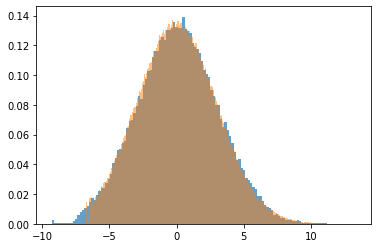

In [165]:
plt.hist(test[..., 0].flatten(), bins='auto', density=True, alpha=0.7);
plt.hist(test2[..., 0].flatten(), bins='auto', density=True, alpha=0.5);

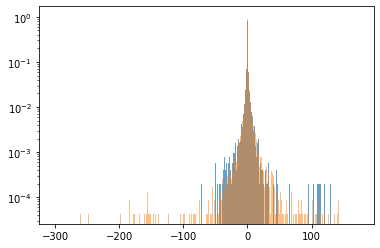

In [167]:
plt.hist(test[..., 1].flatten(), bins='auto', density=True, alpha=0.7);
plt.hist(test2[..., 1].flatten(), bins='auto', density=True, alpha=0.5);
plt.yscale('log')

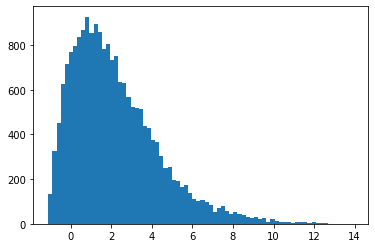

In [125]:
plt.hist(probs[..., 0].flatten(),  bins='auto');

In [97]:
(probs[..., 1] > 2*probs[..., 0].max()).sum()

6776

In [100]:
np.exp(probs[..., 0] - probs[..., 1])

array([[1.10085846e-001, 7.69072464e-007, 9.90133353e-005, ...,
        5.54020285e-001, 0.00000000e+000, 1.24824614e-001],
       [7.20324813e-001, 1.24546022e-001, 5.12182659e-009, ...,
        1.12041698e+000, 9.23366382e-093, 1.64354773e+000],
       [5.04195143e-002, 9.79102289e-002, 2.82634422e-005, ...,
        5.76848495e-001, 1.29720891e-001, 4.23513432e+000],
       ...,
       [1.13717544e+000, 8.62029450e-001, 6.94074554e-051, ...,
        1.40867772e+000, 3.89660024e-001, 1.84227637e-001],
       [1.71893511e+000, 1.18603171e-001, 7.68945121e-118, ...,
        1.12299719e+000, 2.01559675e-001, 9.41616076e-003],
       [1.35535448e+000, 1.29074702e-001, 2.39724530e-167, ...,
        6.82382357e-001, 5.74152614e-002, 8.66069042e-002]])

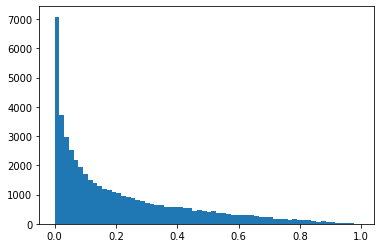

In [59]:
plt.hist(probs[acc==0].flatten(), bins='auto');

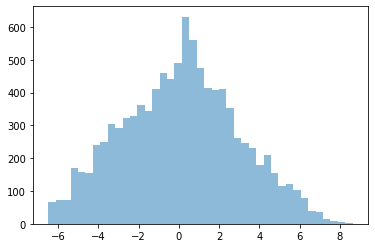

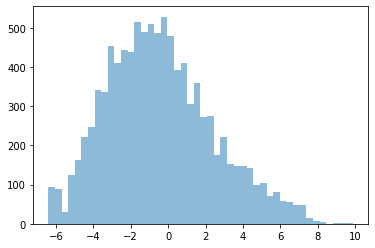

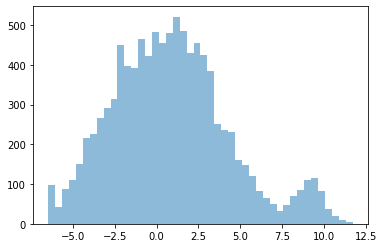

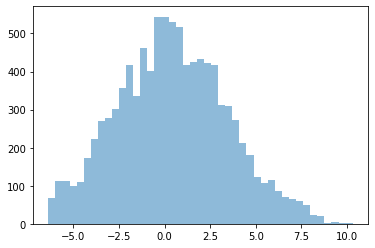

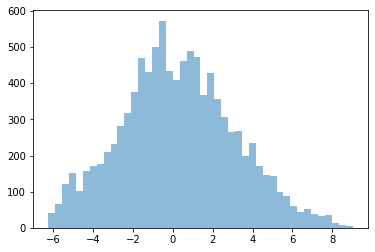

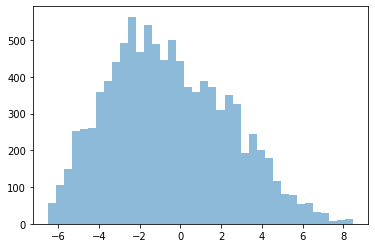

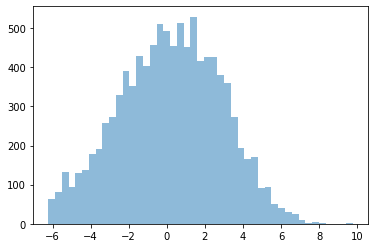

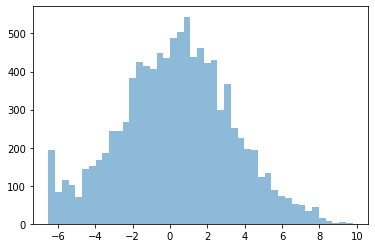

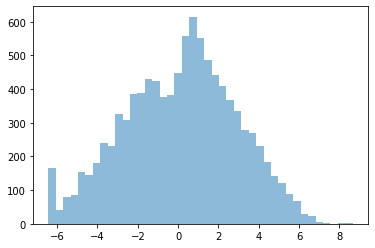

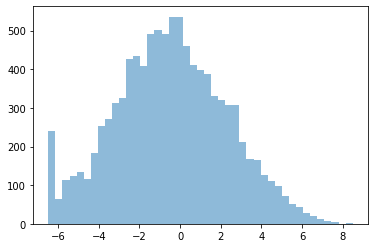

IndexError: index 10 is out of bounds for axis 1 with size 10

In [60]:
# plt.hist(test[::10,...,0].flatten(), bins='auto');
for i in range(20):
    plt.hist(test[:,i,0].flatten(), bins='auto', alpha=0.5);
    plt.show()

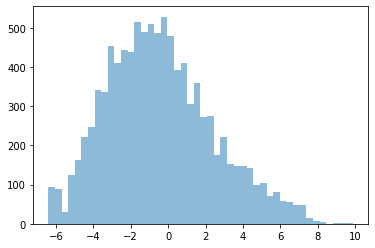

In [61]:
i = 1
plt.hist(test[:,i,0].flatten(), bins='auto', alpha=0.5);

In [41]:
probs[acc == 0 ]

array([0.12661857, 0.23993088, 0.10134589, ..., 0.02046824, 0.17576636,
       0.05763692])

In [254]:
np.allclose(np.exp(probs[..., 0] - probs[..., 1]), tf.exp(probs[..., 0] - probs[..., 1]))

True

(array([1., 1., 1.]),
 array([0.27235145, 0.81519366, 1.35803588, 1.90087809]),
 <BarContainer object of 3 artists>)

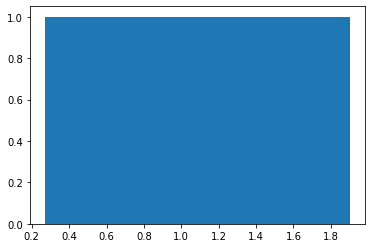

In [276]:
plt.hist(np.random.normal(size=iq.size).reshape(iq.shape), bins='auto')

In [280]:
test = np.array([np.random.normal(size=iq.size).reshape(iq.shape) for i in range(10000)])

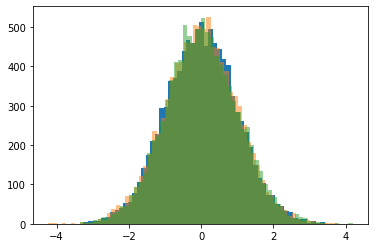

In [287]:
plt.hist(test[:, 0], bins='auto')
plt.hist(test[:, 1], bins='auto', alpha=0.5)
plt.hist(test[:, 2], bins='auto', alpha=0.5);

In [362]:
nn = 10000
qq = np.random.uniform(-2, 2, size=(nn*3)).reshape(nn, 3).astype(float32)
pp = np.random.normal(size=(nn*3)).reshape(nn, 3).astype(float32)

In [363]:
# test = np.array([pyhmc_step_qp(qq[ii], pp[ii], Nleapfrog, step_size) for ii in range(nn)])
test = np.array([samples.grad_log_prob(qq[ii])for ii in range(nn)])

In [364]:
# test2 = np.array([hmc_step_qp(qq[ii], pp[ii], Nleapfrog, step_size) for ii in range(nn)])
test2 = np.array([get_grads(V, qq[ii])[1].numpy() for ii in range(nn)])
# [hmc_step_qp(qq[ii], pp[ii], Nleapfrog, step_size).numpy() for ii in range(10)]

In [372]:
np.allclose(test, -test2)

False

In [379]:
diff = ~np.array([np.allclose(test[i], -test2[i]) for i in range(nn)]) 

In [383]:
test[diff]/test2[diff]

array([[-0.99946659, -0.99999995, -1.00000002],
       [-1.0000162 , -0.99999991, -0.99999997],
       [-1.00004036, -1.00000003, -1.        ],
       [-1.00007177, -1.00000006, -1.00000011],
       [-0.99998672, -1.00000006, -1.00000013],
       [-0.99998008, -0.99999983, -0.99999986],
       [-1.00002251, -0.99999995, -0.99999991],
       [-0.99998344, -0.99999996, -0.99999996],
       [-1.00001234, -0.99999992, -0.99999991],
       [-1.00001628, -0.99999996, -0.99999995],
       [-0.99996336, -1.00000011, -1.00000011],
       [-1.00038119, -0.99999987, -0.99999991],
       [-1.00021666, -1.00000013, -1.00000006],
       [-0.99998301, -0.99999989, -0.99999994],
       [-0.99998438, -0.99999998, -0.99999996],
       [-1.00002051, -0.99999993, -0.99999991],
       [-0.99995704, -0.99999998, -0.99999988],
       [-1.00001692, -1.00000017, -1.00000011],
       [-1.00017313, -1.00000017, -1.00000006]])